In [23]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

## Реалізація МНКО

In [24]:
def RMNK(X, y, s=None, verbose=False, deep_verbose=False, create_dataframe=False):
    assert X.ndim == 2 and X.shape[1] > 0
    m = X.shape[1]
    if m > 1:
        if create_dataframe:
            w, H_inv, RSS, df = RMNK(X[:,:-1], y, s, verbose,
                                     deep_verbose, create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS, df
        else:
            w, H_inv, RSS = RMNK(X[:,:-1], y, s, verbose, deep_verbose,
                                 create_dataframe)
            if s is not None and m > s:
                return w, H_inv, RSS
        # w is of shape = [m-1, 1]; H_inv is of shape = [m-1, m-1]    
        h = (X[:,:-1].T @ X[:,-1]).reshape(-1,1) # shape = [m-1, 1]
        eta = X[:,-1].T @ X[:,-1] # shape = [1, 1]
        alpha = H_inv @ h # shape = [m-1, 1]
        beta = eta - h.T @ alpha # shape = [1, 1]
        beta_inv = 1 / beta # shape = [1, 1]
        gamma = X[:,-1].T @ y # shape = [1, 1]
        nu = beta_inv * (gamma - h.T @ w) # shape = [1, 1]
        w = np.vstack((w - nu * alpha, nu))  # shape = [m, 1]
        H_next_inv = np.vstack((np.hstack((H_inv + beta_inv * alpha @ alpha.T,
                                           (- beta_inv * alpha).reshape(-1, 1))),
                               np.hstack((-beta_inv * alpha.T, beta_inv))))
        RSS_next = (RSS - nu.flatten() ** 2 * beta.flatten())[0]

    else: # 1
        H_inv = np.array([[0]])
        eta = beta = X[:,-1].T @ X[:,-1]
        beta_inv = 1 / beta
        alpha = h = np.array([0])
        gamma = X[:,-1].T @ y
        nu = np.array([beta_inv * gamma])
        w = np.array([nu])
        H_next_inv = np.array(beta_inv).reshape(1, 1)
        RSS_next = (y.T @ y - y.T @ X[:,-1].reshape(-1, 1) @ w)[0]
        if create_dataframe:
            df = pd.DataFrame(columns=['s', 'RSS', 'Cp', 'FPE'])
        
    if verbose:
        print('===============================================')
        print('\tStep {}'.format(m))
        print('===============================================')
        if deep_verbose:
            print('h_{}:\t\t{}'.format(m, h.reshape(-1,1)[:,0]))
            print('eta_{}:\t\t{}'.format(m, eta))
            print('alpha_{}:\t{}'.format(m, alpha.reshape(-1,1)[:,0]))
            print('beta_{}:\t\t{}'.format(m, beta))
            print('gamma_{}:\t{}'.format(m, gamma))
            print('nu_{}:\t\t{}'.format(m, nu))
            print('===============================================')
        print('> θ_{}: {}'.format(m, w[:, 0]))
        print('> H_{}_inv:\n{}'.format(m, H_next_inv))
        print('> RSS_{}: {}'.format(m, RSS_next))
    if create_dataframe:
        Cp = RSS_next + 2 * m
        n = y.shape[0]
        FPE = (n + m) / (n - m) * RSS_next
        df = df.append({'s': m, 'RSS': RSS_next, 'Cp': Cp, 'FPE': FPE},
                       ignore_index=True)
        return w, H_next_inv, RSS_next, df
    return w, H_next_inv, RSS_next

## 1. Модель Фергюльста

### Рівняння моделі
### $N'=μN(k-N) \enspace | \enspace N_0$ 

### Різницеве рівняння
### $\Delta t = 1$
### $N'(t)≈ N(t+1)-N(t) \enspace - \enspace різниця\:вперед$
### $N'(t)≈ N(t)-N(t-1) \enspace - \enspace різниця\:назад$
### $N'(t)≈ \frac{N(t+1)-N(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $Розглядатимемо\: для\: різниці\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}N(t+1)-N(t)=μN(t)[k-N(t)] \\ N(0) = N_0\end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}N(t+1)=(μk+1)N(t)-μN^2(t) \\ N(0) = N_0\end{array} \right. $
### $y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i, \enspace \enspace θ_1 = μk+1; \enspace θ_2 = -μ; \enspace Eξ = 0_n; \enspace cov(ξ) = σ^2I_n$
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = μk+1\\
                  θ_2 = -μ\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $
### $ \Rightarrow \left \{ \begin{array}{ll}
                  μ = -θ_2 \\
                  k = (1 - θ_1) / θ_2
                \end{array}
              \right. $

In [51]:
def Verhulst_model_equation(N, t, μ, k):
    return μ * N * (k - N)

class VerhulstModelConfig(): 
    k = 100
    μ = 0.0001
    N0 = 10
    t_start = 0
    t_end = 500
    num_samples = 50
    num_samples_grid = [10, 50, 100]
    C = 3
    C_grid = [0, 2, 5]

    def __init__(self):
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.N = odeint(Verhulst_model_equation, self.N0, self.t, (self.μ, self.k))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tμ = {}\n\t\t\t\
               k = {}\n\t\t\tN0 = {}\n'.format(self.μ, self.k, self.N0))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        w1 = self.μ * self.k + 1
        w2 = -self.μ
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        μ = - w2
        k = (1 - w1) / w2
        return μ, k
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['N(t)'] = self.N.flatten()
        self.df['N^2(t)'] = np.square(self.N.flatten())
        self.df['N(t+1)'] = np.array(self.df[['N(t)','N^2(t)']]) @ self.theta
        self.df['N(t+1)'] = np.round(self.df['N(t+1)'], self.C)
        self.X = np.array(self.df[['N(t)', 'N^2(t)']])
        self.y = np.array(self.df['N(t+1)'])
        
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['N(t)'],
            y=self.df['N^2(t)'],
            z=self.df['N(t+1)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')
        
    def run_single_RMNK(self, verbose=True, deep_verbose=True):
        print('Recurrent Least Squares Method')
        self.theta_pred = RMNK(self.X, self.y, verbose=verbose, deep_verbose=deep_verbose)[0][:,0]
        self.μ_pred, self.k_pred = self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tμ = {}\tk = {}'.format(self.μ, self.k))
        print('Estimates:\tμ* = {}\tk* = {}'.format(self.μ_pred, self.k_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Verhulst_model_equation, self.N0, t_for_plot,
                                    (μ_pred, k_pred)), 'r')
        plt.show()
        
    def run_grid_RMNK(self, verbose=False):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'μ', 'μ*', 'k', 'k*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                theta_pred = RMNK(self.X, self.y, verbose=False)[0][:,0]
                μ_pred, k_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'μ': self.μ,
                                             'μ*': μ_pred,
                                             'k': self.k,
                                             'k*': k_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C,
                                                           self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tμ* = {: 12.8}\tk* = {: 12.8}'.format(μ_pred, k_pred))

#         print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
#         print('True init.  params values:\tμ = {}\tk = {}'.format(self.μ, float(self.k)))
        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['μ', 'μ*', 'k', 'k*']]],
                         axis=1)

Initial parameters:	μ = 0.0001
			               k = 100
			N0 = 10

Noise generation: C = 3
Sample length: n = 50
Time starting from 0 to 500                with discretization frequency 10



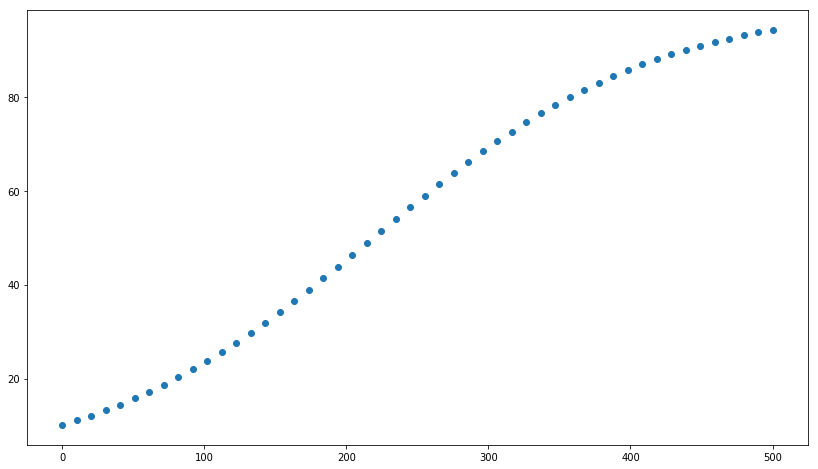

Intermediate parameters values: θ_1 = 1.01	θ_2 = -0.0001
Regression model: y = (1.01) * x1 + (-0.0001) * x2


,i,t,N(t),N^2(t),N(t+1)
0,1,0,10.000000,100.000000,10.090
1,2,10,10.956582,120.046684,11.054
2,3,20,11.992475,143.819461,12.098
3,4,30,13.111886,171.921546,13.226
4,5,40,14.318785,205.027597,14.441
5,6,51,15.616808,243.884680,15.749
6,7,61,17.009139,289.310822,17.150
7,8,71,18.498393,342.190549,18.649
8,9,81,20.086481,403.466709,20.247
9,10,91,21.774481,474.128027,21.945


In [52]:
config = VerhulstModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [53]:
# config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		192021.11695382808
alpha_1:	[0]
beta_1:		192021.11695382808
gamma_1:	192454.57239914758
nu_1:		[1.00225733]
> θ_1: [1.00225733]
> H_1_inv:
[[5.20776056e-06]]
> RSS_1: 0.5984206103312317
	Step 2
h_2:		[14865979.31260227]
eta_2:		1210738873.994198
alpha_2:	[77.41846078]
beta_2:		[[59837637.56477976]]
gamma_2:	14893552.797599493
nu_2:		[[-0.0001]]
> θ_2: [ 1.00999944e+00 -1.00003420e-04]
> H_2_inv:
[[ 1.05372445e-04 -1.29380878e-06]
 [-1.29380878e-06  1.67118897e-08]]
> RSS_2: 3.305702054645643e-06

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.01	θ_2 = -0.0001
Estimates:	θ_1* = 1.0099994430189032	θ_2* = -0.00010000341994463542

INITIAL PARAMETERS
True values:	μ = 0.0001	k = 100
Estimates:	μ* = 0.00010000341994463542	k* = 99.99101055183083


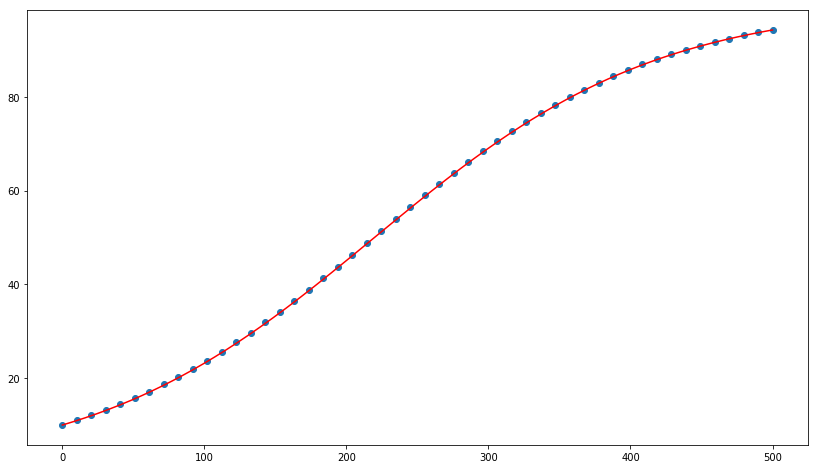

In [54]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [62]:
config.run_grid_RMNK(verbose=False)

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,μ,μ*,k,k*
0,0.0,10.0,1.01,0.998957,-0.0001,0.000044,0.0001,-0.000044,100.0,23.826999
1,0.0,50.0,1.01,1.010265,-0.0001,-0.000106,0.0001,0.000106,100.0,96.768521
2,0.0,100.0,1.01,1.009688,-0.0001,-0.000097,0.0001,0.000097,100.0,100.083587
3,2.0,10.0,1.01,1.009857,-0.0001,-0.000098,0.0001,0.000098,100.0,100.559471
4,2.0,50.0,1.01,1.009994,-0.0001,-0.000100,0.0001,0.000100,100.0,100.105598
5,2.0,100.0,1.01,1.009956,-0.0001,-0.000099,0.0001,0.000099,100.0,100.113571
6,5.0,10.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000233
7,5.0,50.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000141
8,5.0,100.0,1.01,1.010000,-0.0001,-0.000100,0.0001,0.000100,100.0,100.000091


---

## 2. Рівняння згасаючих коливань

### Модель рівняння
### $x''+2δ x'+ω_0^2 x=0$

### Різницеве рівняння
### $\Delta t = 1$
### $x'(t)≈ x(t+1)-x(t) \enspace - \enspace різниця\:вперед$
### $x'(t)≈ x(t)-x(t-1) \enspace - \enspace різниця\:назад$
### $x'(t)≈ \frac{x(t+1)-x(t-1)}{2} \enspace - \enspace центральна\:різниця$
### $x''(t)≈ x(t+1)-2x(t)+x(t-1)$
### $Розглянемо\: для\: апроксимації\: різницею\: вперед:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+2δ[x(t+1)-x(t)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2+2δ-ω_0^2}{1+2δ}x(t+1)-\frac{1}{1+2δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2+2δ-ω_0^2}{1+2δ}\\
                  θ_2 = -\frac{1}{1+2δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

In [74]:
def Oscillation_model_equation(x, t, δ, ω0_sqr):
    #x_0' = x_1 = x'
    #x_1' = x'' = - 2 * δ * x[1] - (ω0 ** 2) * x[0]
    return [x[1],  - 2 * δ * x[1] - ω0_sqr * x[0]]        

class OscillationModelConfig(): 
    δ = 0.005
    ω0_sqr = 0.01
    x0 = 5
    x00 = 2
    t_start = 0
    t_end = 500
    num_samples = 80
    num_samples_grid = [30, 80, 150]
    C = 2
    C_grid = [0, 2, 5]

    def __init__(self, difference='forward'):
        self.difference = difference
        self.theta = self.init_to_inter_params()
        self.compile()
        
    def compile(self):
        self.h = int((self.t_end - self.t_start) / (self.num_samples - 1))
        self.t = np.linspace(self.t_start, self.t_end, num=self.num_samples)
        self.x = odeint(Oscillation_model_equation,
                        np.array([self.x0, self.x00]),
                        self.t, (self.δ, self.ω0_sqr))
        self.x1 = self.x0 + self.x00
        self.x11 = self.x00
        self.x_1 = odeint(Oscillation_model_equation,
                          np.array([self.x1, self.x11]), self.t+1,
                          (self.δ, self.ω0_sqr))
        self.create_data_sample()
        
    def recompile(self, C, num_samples):
        self.C = C
        self.num_samples = num_samples
        self.compile()
        
    def show(self):
        print('Initial parameters:\tδ = {}\n\t\t\tω0^2 = {}\
              \n\t\t\tx0 = {}\n\t\t\tx00 = {}\n'.format(self.δ, self.ω0_sqr,
                                                        self.x0, self.x00))
        print('Noise generation: C = {}'.format(self.C))
        print('Sample length: n = {}'.format(self.num_samples))
        print('Time starting from {} to {} \
               with discretization frequency {}\n'.format(self.t_start,
                                                          self.t_end,
                                                          self.h))
        
    def init_to_inter_params(self):
        if self.difference == 'center':
            divider = 1 + self.δ
            w1 = (2 - self.ω0_sqr) / divider
            w2 = - (1 - self.δ) / divider
        elif self.difference == 'forward':
            divider = 1 + 2 * self.δ
            w1 = (2 + 2 * self.δ - self.ω0_sqr) / divider
            w2 = - 1 / divider
        return np.array([w1, w2])

    def inter_to_init_params(self, w1, w2):
        if self.difference == 'center':
            δ = (1 + w2) / (1 - w2)
            ω0_sqr = (2 - 2 * w1 - 2 * w2) / (1 - w2)
        elif self.difference == 'forward':
            δ = - (1 / w2 + 1) / 2
            ω0_sqr = 1 - 1 / w2 + w1 / w2
        return δ, ω0_sqr
    
    def create_data_sample(self):
        self.df = pd.DataFrame()
        self.df['i'] = range(1, self.num_samples+1)
        self.df['t'] = list(map(int, self.t))
        self.df['x(t)'] = self.x[:,0].flatten()
        self.df['x(t+1)'] = self.x_1[:,0].flatten()
        self.df['x(t+2)'] = np.array(self.df[['x(t)','x(t+1)']]) @ self.theta
        self.df['x(t+2)'] = np.round(self.df['x(t+2)'], self.C)
        self.X = np.array(self.df[['x(t)', 'x(t+1)']])
        self.y = np.array(self.df['x(t+2)'])
    
    def plot_3D(self):
        trace1 = go.Scatter3d(
            x=self.df['x(t)'],
            y=self.df['x(t+1)'],
            z=self.df['x(t+2)'],
            mode='markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5
                ),
                opacity=0.8
            )
        )

        data = [trace1]
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, filename='simple-3d-scatter')

    def run_single_RMNK(self, verbose=True, deep_verbose=False):
        print('Recurrent Least Squares Method')
        self.theta_pred = RMNK(self.X, self.y, verbose=verbose, deep_verbose=deep_verbose)[0][:,0]
        self.δ_pred, self.ω0_sqr_pred = self.inter_to_init_params(*self.theta_pred)
        print('=============================================')
        print('\nINTERMEDIATE PARAMETERS')
        print('True values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
        print('Estimates:\tθ_1* = {}\tθ_2* = {}'.format(*self.theta_pred))
        print('\nINITIAL PARAMETERS')
        print('True values:\tδ = {}\t\t\tω0^2 = {}'.format(self.δ, self.ω0_sqr))
        print('Estimates:\tδ* = {}\tω0^2* = {}'.format(self.δ_pred, self.ω0_sqr_pred))
        plt.scatter(self.t, self.y)
        t_for_plot = np.linspace(self.t_start, self.t_end,
                                 num=self.num_samples * 10)
        plt.plot(t_for_plot, odeint(Oscillation_model_equation, 
                                    np.array([self.x0, self.x00]),
                                    t_for_plot,
                                    (self.δ_pred, self.ω0_sqr_pred))[:,0], 'r')
        plt.show()
        
    def run_grid_RMNK(self, verbose=True):
        intermediate_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                          'θ_1', 'θ_1*',
                                                          'θ_2', 'θ_2*'])
        initial_estimates_df = pd.DataFrame(columns=['C', 'num_samples',
                                                     'δ', 'δ*',
                                                     'ω0_sqr', 'ω0_sqr*'])
        for C in self.C_grid:
            for num_samples in self.num_samples_grid: 
                self.recompile(C, num_samples)
                intermediate_estimates_df
                theta_pred = RMNK(self.X, self.y, verbose=False)[0][:,0]
                δ_pred, ω0_sqr_pred = self.inter_to_init_params(*theta_pred)
                intermediate_estimates_df = \
                intermediate_estimates_df.append({'C': self.C,
                                                  'num_samples': self.num_samples,
                                                  'θ_1': self.theta[0],
                                                  'θ_1*': theta_pred[0],
                                                  'θ_2': self.theta[1],
                                                  'θ_2*': theta_pred[1]},
                                                 ignore_index=True)
                initial_estimates_df = \
                initial_estimates_df.append({'C': self.C,
                                             'num_samples': self.num_samples,
                                             'δ': self.δ,
                                             'δ*': δ_pred,
                                             'ω0_sqr': self.ω0_sqr,
                                             'ω0_sqr*': ω0_sqr_pred},
                                             ignore_index=True)
                if verbose:
                    print('=============================================================')
                    print('C: {}\t num_samples: {}'.format(self.C, self.num_samples))
                    print('\nINTERMEDIATE PARAMETERS')
                    print('Estimates:\tθ_1* = {: 12.8}\tθ_2* = {:12.8}'.format(*theta_pred))
                    print('\nINITIAL PARAMETERS')
                    print('Estimates:\tδ* = {: 12.8}\tk* = {: 12.8}'.format(δ_pred,
                                                                            ω0_sqr_pred))

#         print('True inter. params values:\tθ_1 = {}\tθ_2 = {}'.format(*self.theta))
#         print('True init.  params values:\tδ = {}\t\t\tω0^2 = {}'.format(self.δ, self.ω0_sqr))
        return pd.concat([intermediate_estimates_df,
                          initial_estimates_df[['δ', 'δ*', \
                                                'ω0_sqr', 'ω0_sqr*']]],
                         axis=1)

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



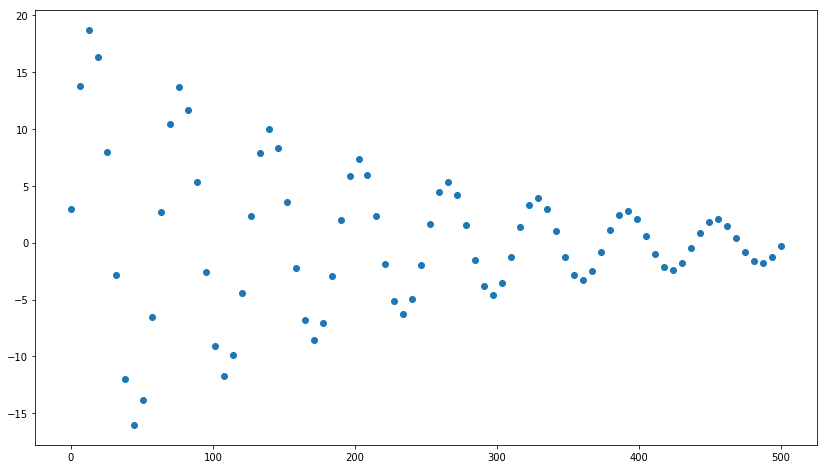

Intermediate parameters values: θ_1 = 1.98019801980198	θ_2 = -0.9900990099009901
Regression model: y = (1.98019801980198) * x1 + (-0.9900990099009901) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [75]:
config = OscillationModelConfig()
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

In [76]:
# config.plot_3D()

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		6597.77701645746
alpha_1:	[0]
beta_1:		6597.77701645746
gamma_1:	6321.674770933229
nu_1:		[0.95815223]
> θ_1: [0.95815223]
> H_1_inv:
[[0.00015157]]
> RSS_1: 53.8545504470776
	Step 2
h_2:		[6810.34526847]
eta_2:		7084.704576047738
alpha_2:	[1.03221816]
beta_2:		[[54.94249709]]
gamma_2:	6470.951712038432
nu_2:		[[-0.99004972]]
> θ_2: [ 1.98009953 -0.99004972]
> H_2_inv:
[[ 0.0195441  -0.01878725]
 [-0.01878725  0.01820085]]
> RSS_2: 1.2412897376634646e-09

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.980099534831608	θ_2* = -0.9900497206062433

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.005000015472339794	ω0^2* = 0.009999936857461188


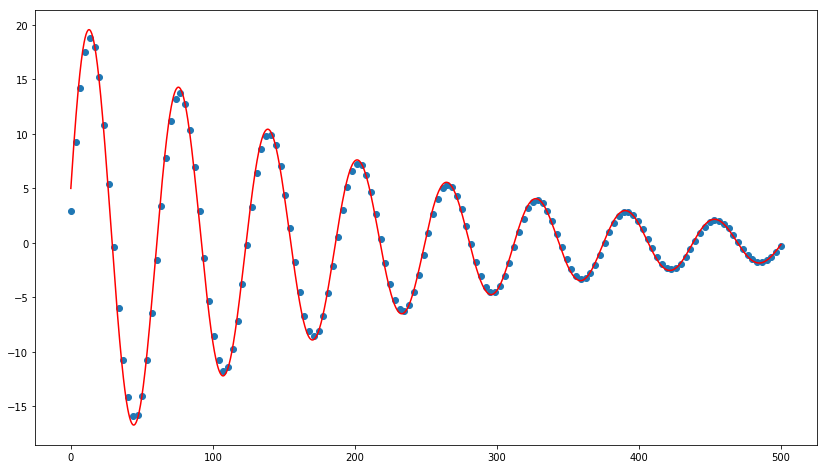

In [92]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [93]:
forward_df = config.run_grid_RMNK(verbose=False)
forward_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888
5,2.0,150.0,1.9801,1.979936,-0.99005,-0.989861,0.005,0.005095,0.01,0.009975
6,5.0,30.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
7,5.0,80.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
8,5.0,150.0,1.9801,1.980100,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000


### $Розглянемо\: для\: апроксимації\: центральною\: різницею:$
### $ \Rightarrow \left \{ \begin{array}{ll}x(t+1)-2x(t)+x(t-1)+δ[x(t+1)-x(t-1)]+ω_0^2 x(t)=0 \\ x(0) = x_0\\ x(1) = x(0) + x'(0) = x_0 + x'_0 \end{array} \right. $
### $ \iff \left \{ \begin{array}{ll}x(t+2)=\frac{2-ω_0^2}{1+δ}x(t+1)-\frac{1-δ}{1+δ}x(t) \\ x(0) = x_0\\ x(1) = x_0 + x'_0 \end{array} \right. $
### $ \left \{ \begin{array}{ll}
                  y_i = θ_1 x_{i1} +  θ_2 x_{i2} + ξ_i\\
                  θ_1 = \frac{2-ω_0^2}{1+δ}\\
                  θ_2 = -\frac{1-δ}{1+δ}\\
                  Eξ = 0_n;\enspace cov(ξ) = σ^2I_n
                \end{array}
              \right. $

Initial parameters:	δ = 0.005
			ω0^2 = 0.01              
			x0 = 5
			x00 = 2

Noise generation: C = 2
Sample length: n = 80
Time starting from 0 to 500                with discretization frequency 6



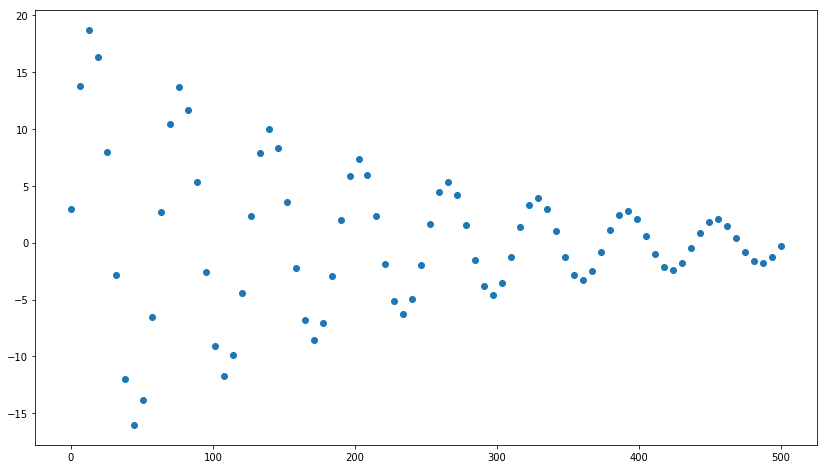

Intermediate parameters values: θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Regression model: y = (1.9800995024875623) * x1 + (-0.9900497512437811) * x2


,i,t,x(t),x(t+1),x(t+2)
0,1,0,5.000000,7.000000,2.97
1,2,6,15.514879,17.135487,13.76
2,3,12,19.560926,20.217068,18.72
3,4,18,16.016072,15.520598,16.35
4,5,25,6.676531,5.286058,7.99
5,6,31,-4.596447,-6.305073,-2.86
6,7,37,-13.452646,-14.818532,-11.97
7,8,44,-16.715857,-17.247299,-16.02
8,9,50,-13.504159,-13.052839,-13.82
9,10,56,-5.420258,-4.215867,-6.56


In [99]:
config = OscillationModelConfig(difference='center')
config.show()

plt.scatter(config.t, config.y)
plt.show()
print('Intermediate parameters values: θ_1 = {}\tθ_2 = {}'.format(*config.theta))
print('Regression model: y = ({}) * x1 + ({}) * x2'.format(*config.theta))
config.df.head(10)

Recurrent Least Squares Method
	Step 1
h_1:		[0]
eta_1:		3496.0743024036183
alpha_1:	[0]
beta_1:		3496.0743024036183
gamma_1:	3349.2782321079894
nu_1:		[0.95801117]
> θ_1: [0.95801117]
> H_1_inv:
[[0.00028604]]
> RSS_1: 29.447942916061493
	Step 2
h_2:		[3609.56221018]
eta_2:		3756.7578218698554
alpha_2:	[1.03246153]
beta_2:		[[30.02371322]]
gamma_2:	3428.2668093266866
nu_2:		[[-0.99035405]]
> θ_2: [ 1.98051363 -0.99035405]
> H_2_inv:
[[ 0.03579053 -0.0343882 ]
 [-0.0343882   0.03330701]]
> RSS_2: 0.0006504761413275162

INTERMEDIATE PARAMETERS
True values:	θ_1 = 1.9800995024875623	θ_2 = -0.9900497512437811
Estimates:	θ_1* = 1.9805136264573653	θ_2* = -0.9903540525860844

INITIAL PARAMETERS
True values:	δ = 0.005			ω0^2 = 0.01
Estimates:	δ* = 0.004846347513590607	ω0^2* = 0.00988811625342075


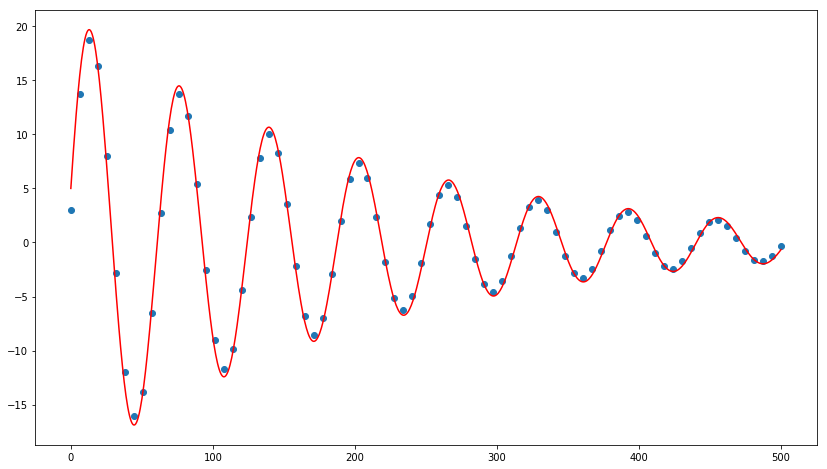

In [100]:
config.run_single_RMNK(verbose=True, deep_verbose=True)

In [101]:
center_df = config.run_grid_RMNK(verbose=False)
center_df

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888
5,2.0,150.0,1.9801,1.979936,-0.99005,-0.989861,0.005,0.005095,0.01,0.009975
6,5.0,30.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
7,5.0,80.0,1.9801,1.980099,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000
8,5.0,150.0,1.9801,1.980100,-0.99005,-0.990050,0.005,0.005000,0.01,0.010000


In [102]:
center_df['difference'] = 'center'
forward_df['difference'] = 'forward'
pd.concat([center_df, forward_df], axis=0).sort_values(by=['C',
                                                           'num_samples',
                                                           'difference'])

,C,num_samples,θ_1,θ_1*,θ_2,θ_2*,δ,δ*,ω0_sqr,ω0_sqr*,difference
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134,center
0,0.0,30.0,1.9801,2.092809,-0.99005,-1.100300,0.005,-0.047755,0.01,0.007134,forward
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574,center
1,0.0,80.0,1.9801,1.959643,-0.99005,-0.966105,0.005,0.017240,0.01,0.006574,forward
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481,center
2,0.0,150.0,1.9801,1.985392,-0.99005,-0.991847,0.005,0.004093,0.01,0.006481,forward
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935,center
3,2.0,30.0,1.9801,1.980023,-0.99005,-0.989908,0.005,0.005071,0.01,0.009935,forward
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888,center
4,2.0,80.0,1.9801,1.980514,-0.99005,-0.990354,0.005,0.004846,0.01,0.009888,forward


## 3. Дослідження закономірностей задачі структурно параметричної ідентифікації 

### $RSS(s)$
### $C_p(s) = RSS(s) + 2s$
### $FPE(s) = \frac{n + s}{n - s} RSS(s)$

In [103]:
class ModelConfig():
    m = 5
    n = 10
    n_grid = [10, 30, 100]
    theta = np.array([3, -2, 1, 0, 0])
    a = 0
    b = 2
    sigma = 0.01
    sigma_grid = [0.1, 0.5, 1]
    s = 5
    s_grid = [1, 2, 3, 4, 5]
    
    def __init__(self):
        self.compile()
        
    def generate_noise_and_output(self):
        self.ksi = np.random.normal(0, self.sigma, size=self.n)
        self.y = self.X @ self.theta + self.ksi
        
    def compile(self):
        self.X = np.random.uniform(self.a, self.b, size=(self.n, self.m))
        self.generate_noise_and_output()
        
    def recompile(self, n, sigma):
        self.n = n
        self.sigma = sigma
        self.compile()
        
    def show(self):
#         print('Regressors: m = {}'.format(self.m))
#         print('True parameters: θ = {}'.format(self.theta))
        print('Sample length: n = {}'.format(self.n))
        print('Noise generation: σ = {}'.format(self.sigma))
        print('X[:10]:\n{}'.format(self.X[:10]))
        print('y[:10]:\n{}'.format(self.y[:10]))

    def run_RMNK_model_selection(self):
        for i, n in enumerate(self.n_grid): 
            for j, sigma in enumerate(self.sigma_grid):
                self.recompile(n, sigma)
                print('--------------------------------------------------------------')
                print('\t\t\tSAMPLE #{}'.format(i * len(self.n_grid) + j + 1))
                print('--------------------------------------------------------------')
                print('\t\tCONFUGURATIONS & DATA')
                self.show()
                print('\n\t\tRLSM ITERATIONS')
                theta_pred, _, _, df = RMNK(self.X, self.y, s=self.s,
                                            verbose=True, create_dataframe=True)
                print('\n\t\t\tRESULTS')
                print('\nPARAMETERS')
                print('True values:\tθ: {}'.format(self.theta))
                print('Estimates:\tθ*: {}'.format(theta_pred[:,0]))
                plt.plot(df['s'], df['RSS'], label='RSS')
                plt.plot(df['s'], df['Cp'], label='Cp')
                plt.plot(df['s'], df['FPE'], label='FPE')
                plt.legend()
                plt.show()
                print(df)
                print('s* by Cp:  {}'.format(np.array(df['Cp']).argmin()+1))
                print('s* by FPE: {}'.format(np.array(df['FPE']).argmin()+1))
                print()

In [104]:
config = ModelConfig()

In [105]:
config.generate_noise_and_output()
config.show()

Sample length: n = 10
Noise generation: σ = 0.01
X[:10]:
[[1.63814072 1.89766039 1.89184617 0.11998441 0.80884482]
 [0.36408436 0.51540828 0.11361621 0.81001399 0.06413189]
 [0.24209836 0.91243439 0.76688485 1.28870026 0.17675167]
 [0.81326502 0.0093654  0.23506706 0.20407554 1.06132348]
 [0.8525336  0.41574906 0.32625517 1.54702859 0.4941146 ]
 [0.41472952 1.23018162 0.89440096 1.95316156 1.26320371]
 [0.38865084 0.63985157 0.28089099 0.37613329 0.10644867]
 [1.31883163 0.05194779 1.10389646 0.78676596 1.60580423]
 [1.19428173 1.52165065 1.07412636 0.75275651 1.56026414]
 [0.73930644 0.92063664 0.09224623 0.80002571 1.10830795]]
y[:10]:
[ 3.00685293  0.16232205 -0.32493478  2.66022387  2.04053393 -0.32058792
  0.18088242  4.94888799  1.61819048  0.47728717]


--------------------------------------------------------------
			SAMPLE #1
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.1
X[:10]:
[[0.10944664 0.53099113 0.28171683 0.89873793 1.59454517]
 [1.64984255 0.04084459 0.10740614 0.82508724 0.65142551]
 [0.30585864 1.80257967 0.26823729 0.96468783 1.10283354]
 [0.11304458 1.92837313 1.79313195 1.78794237 0.82225528]
 [1.42322911 0.98081912 0.25518362 0.31602235 0.13869243]
 [1.45393695 1.10145811 0.46549739 0.67490733 0.08288291]
 [0.74055605 1.1314859  0.40313885 0.90637992 0.96136674]
 [0.11826677 1.13887299 0.97105255 1.5399134  0.24315917]
 [0.936038   1.78516871 1.57354137 1.88764552 0.09666207]
 [1.15444059 1.75840695 1.58193417 1.23309329 0.02478837]]
y[:10]:
[-0.3571798   4.90059755 -2.43093455 -1.79182848  2.37942878  2.55567895
  0.21029229 -0.86864283  0.59354928  1.63439959]

		RLSM ITERATIONS
	Step 1
> θ_1: [1.71239091]
> H_1_inv:
[[0.1025524

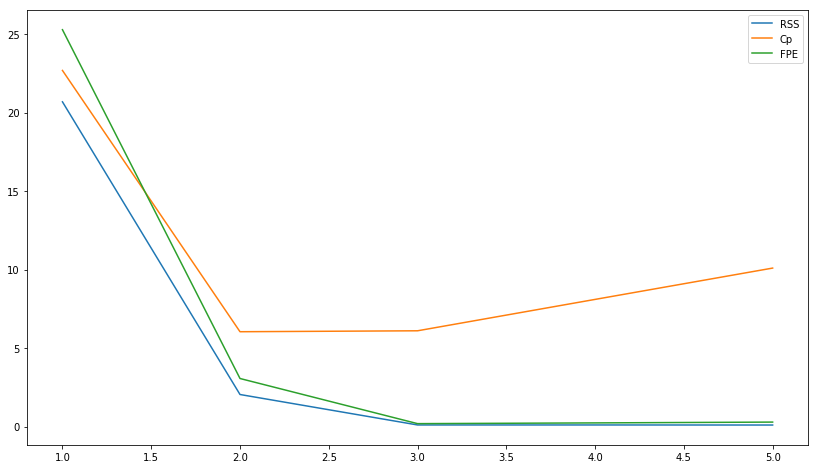

     s        RSS         Cp        FPE
0  1.0  20.686012  22.686012  25.282904
1  2.0   2.038757   6.038757   3.058135
2  3.0   0.098404   6.098404   0.182750
3  4.0   0.098245   8.098245   0.229237
4  5.0   0.093749  10.093749   0.281247
s* by Cp:  2
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #2
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 0.5
X[:10]:
[[1.47024661 0.78818473 0.34702642 1.27882648 1.18146324]
 [1.78140131 0.13339491 1.24175457 1.84624202 0.98397622]
 [1.02525673 1.7256851  0.82339895 1.7042044  0.84759276]
 [0.1143993  0.5443466  0.52787933 1.03111479 1.59211976]
 [1.43806534 0.24313893 1.20338154 1.1554557  1.31803741]
 [0.54466408 1.7796209  0.55958411 0.21835651 0.38236575]
 [1.759071   0.4765864  1.74224429 0.50737418 1.41118029]
 [1.77812749 0.73807682 1.25164128 1.27982574 1.45841948]
 [0.16104026 1.76739251 0.13271058 0.52297188 0.84

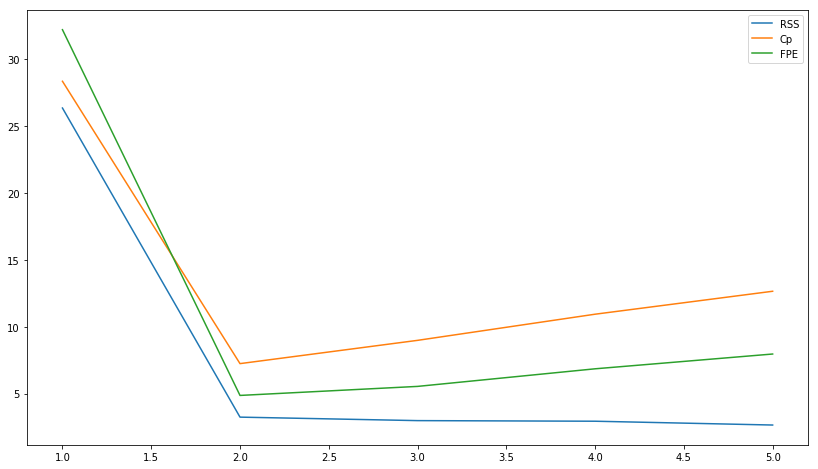

     s        RSS         Cp        FPE
0  1.0  26.351406  28.351406  32.207273
1  2.0   3.244599   7.244599   4.866899
2  3.0   2.984104   8.984104   5.541908
3  4.0   2.938928  10.938928   6.857499
4  5.0   2.654128  12.654128   7.962384
s* by Cp:  2
s* by FPE: 2

--------------------------------------------------------------
			SAMPLE #3
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 10
Noise generation: σ = 1
X[:10]:
[[1.23523438 0.75126595 0.79256964 0.44829597 1.67950151]
 [0.56590487 1.91926558 0.80826666 0.23236222 0.90485555]
 [1.17988724 1.96528872 0.48989518 1.07399311 0.63144885]
 [1.27001279 0.65075552 1.09045836 1.13740359 0.20492794]
 [0.51229076 0.47957321 1.8114372  0.48186914 1.38569587]
 [1.9420566  0.05467748 0.65991193 0.52509248 1.40257398]
 [0.23452387 0.67465305 1.08320247 1.72466775 0.2956556 ]
 [0.11941211 0.6684237  0.83371461 1.38599751 1.74802583]
 [1.07196345 1.03353871 0.6168457  0.51651816 0.5327

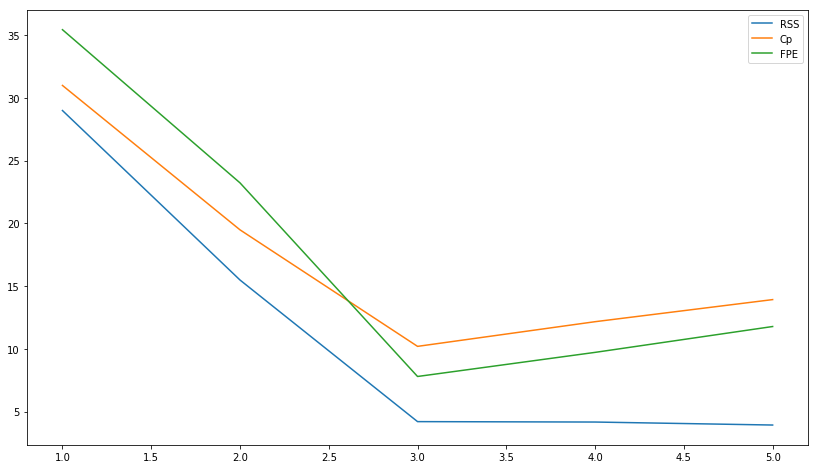

     s        RSS         Cp        FPE
0  1.0  29.000708  31.000708  35.445310
1  2.0  15.488376  19.488376  23.232565
2  3.0   4.198652  10.198652   7.797496
3  4.0   4.165633  12.165633   9.719810
4  5.0   3.927019  13.927019  11.781058
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #4
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.1
X[:10]:
[[0.98346793 0.90008008 0.32926665 1.36945951 0.65785581]
 [1.97693688 1.20907509 1.13097718 0.86795391 1.24912574]
 [1.94950336 1.78105099 1.44259627 1.03585077 0.60360249]
 [0.70534158 1.00005387 0.93452968 0.51841608 1.28600616]
 [0.06659131 1.42692686 0.21255476 1.17295534 0.87001371]
 [1.8654063  0.54746728 0.25958036 1.83228325 1.58796899]
 [0.14100892 0.41702321 0.11983411 1.41579677 0.9724599 ]
 [1.74923722 1.90513048 0.03073584 0.77627762 1.81616987]
 [0.36652772 0.1151126  0.05233852 1.44621465 0.13

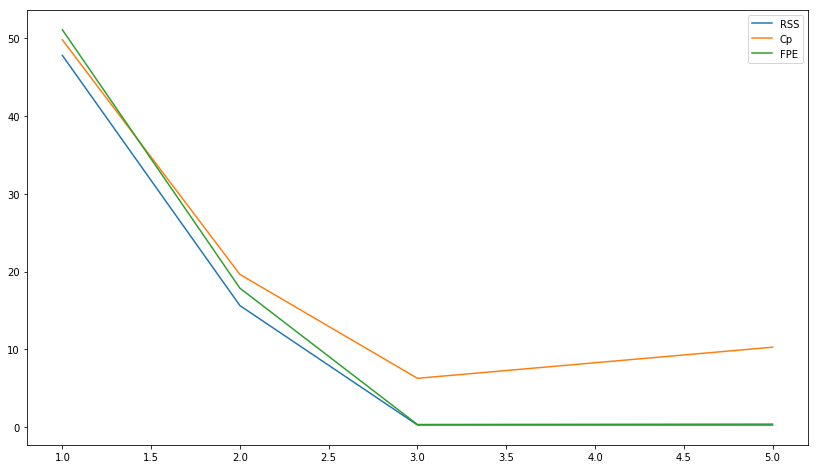

     s        RSS         Cp        FPE
0  1.0  47.788965  49.788965  51.084756
1  2.0  15.643268  19.643268  17.878020
2  3.0   0.295665   6.295665   0.361369
3  4.0   0.294079   8.294079   0.384565
4  5.0   0.292883  10.292883   0.410037
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #5
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 0.5
X[:10]:
[[1.32435886 0.86849441 1.95348899 1.10645864 0.4003615 ]
 [0.77912917 1.82198402 0.6970655  0.50885241 1.61650199]
 [1.05726418 1.33261769 0.47339732 0.39217986 0.52315406]
 [0.45254832 1.18008396 1.67283717 0.21687231 0.63822148]
 [1.27576801 1.5893657  1.74210116 1.2828587  1.14013602]
 [0.07012919 1.9303669  1.48099788 0.79113498 0.93828585]
 [1.79532072 1.36711402 0.93564067 1.65305303 0.18348454]
 [1.15072533 0.73825598 0.53714742 1.50711352 0.91731192]
 [0.46118793 1.83152997 0.32234842 0.13111277 0.63

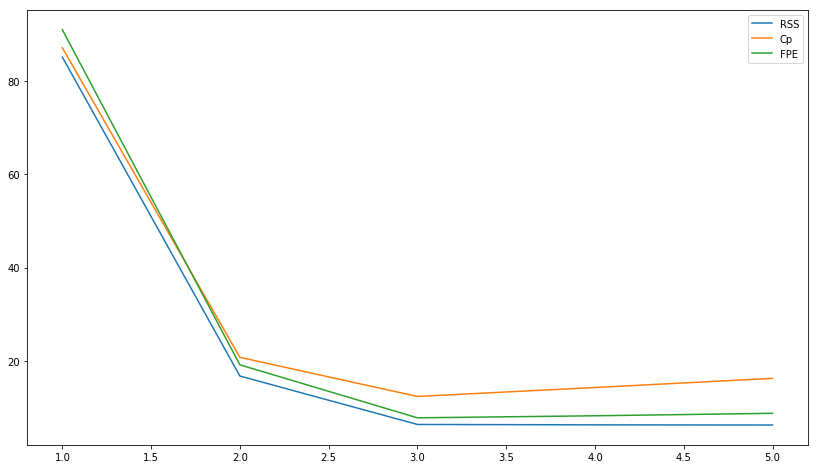

     s        RSS         Cp        FPE
0  1.0  85.120822  87.120822  90.991224
1  2.0  16.778597  20.778597  19.175540
2  3.0   6.397948  12.397948   7.819714
3  4.0   6.314468  14.314468   8.257381
4  5.0   6.274866  16.274866   8.784812
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #6
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 30
Noise generation: σ = 1
X[:10]:
[[0.85541525 0.5370527  0.12039939 0.46122958 0.69171684]
 [0.35189678 0.74876518 0.90807567 0.85498079 1.74270818]
 [1.02322851 0.49471977 0.67245163 0.72026299 0.05308816]
 [1.3633221  1.49961759 1.46943268 1.61773485 0.55004303]
 [1.42777463 1.34102659 0.08833948 0.22725761 1.64200853]
 [0.67769814 1.5889017  0.70831158 0.31757545 1.90937956]
 [1.74819508 1.85844779 0.95017793 0.43838633 1.38680946]
 [1.80350486 1.53110205 0.2469024  0.28715749 1.01633074]
 [0.28288388 0.21776836 1.11539613 0.46295673 1.4840

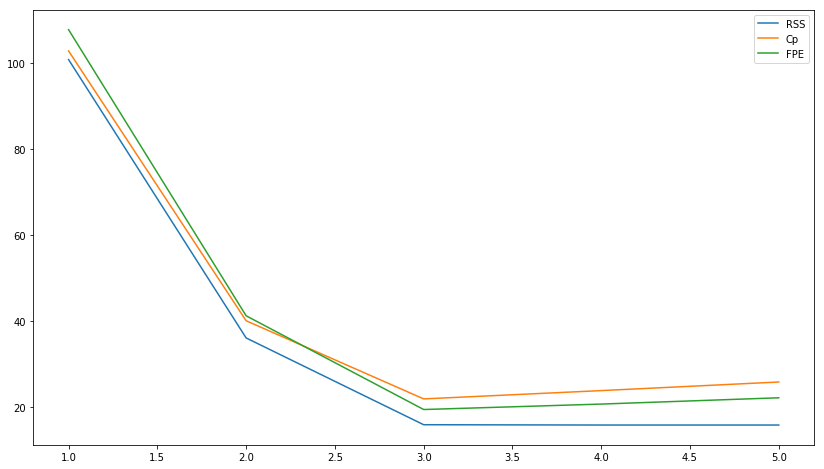

     s         RSS          Cp         FPE
0  1.0  100.743851  102.743851  107.691702
1  2.0   36.058478   40.058478   41.209689
2  3.0   15.897282   21.897282   19.430012
3  4.0   15.825101   23.825101   20.694362
4  5.0   15.824858   25.824858   22.154801
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #7
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.1
X[:10]:
[[1.71615134 0.76778485 0.54383942 1.90953554 1.85262225]
 [1.74068112 0.7574541  1.69577244 0.9556345  1.34456847]
 [0.22632922 0.54921862 0.552081   0.4228506  0.90079934]
 [1.79027929 0.38605488 0.86801206 0.33009663 1.01969091]
 [1.40154016 1.85689983 1.88551775 1.87069549 1.66615185]
 [1.82486317 1.27542502 1.54093953 1.44998669 1.20842576]
 [0.50520323 1.80688514 1.66034992 0.65957416 0.76542076]
 [1.22522949 1.26941303 1.09933504 1.27649162 0.64176032]
 [0.60056997 0.98184701 0.85518

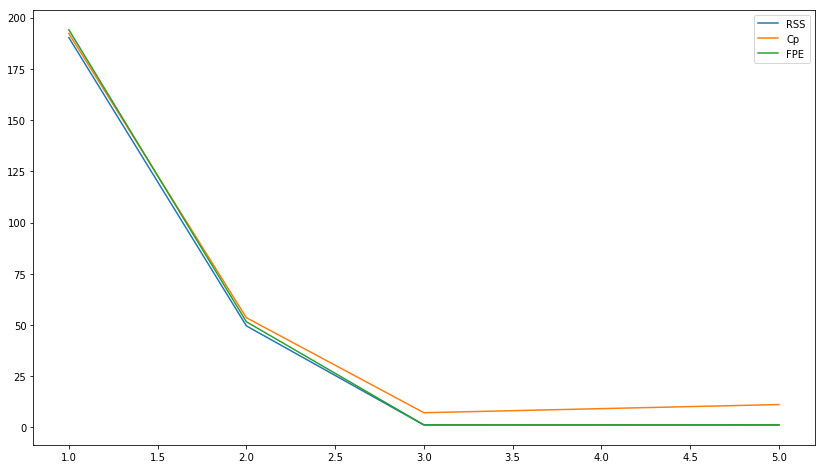

     s         RSS          Cp         FPE
0  1.0  190.296338  192.296338  194.140709
1  2.0   49.562525   53.562525   51.585486
2  3.0    1.181831    7.181831    1.254934
3  4.0    1.173475    9.173475    1.271265
4  5.0    1.169381   11.169381    1.292474
s* by Cp:  3
s* by FPE: 3

--------------------------------------------------------------
			SAMPLE #8
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 0.5
X[:10]:
[[0.75499222 1.00827586 1.6960575  0.33517149 1.72175665]
 [1.49248652 1.63275879 0.68651469 0.38453077 1.44653979]
 [1.36202915 1.61133954 1.79839951 1.99547244 1.40134851]
 [1.1738537  1.54110145 1.11338227 0.31131995 1.93662562]
 [0.80627966 1.36137051 0.81307249 1.09875553 1.66189158]
 [0.69184645 1.4981172  1.21887062 1.59211547 1.87724496]
 [0.18204839 0.93711621 1.1889982  1.30200425 1.48275808]
 [1.4124794  1.87188422 1.83774958 0.47475144 0.58378714]
 [0.46834845 1.95675407 0.53312

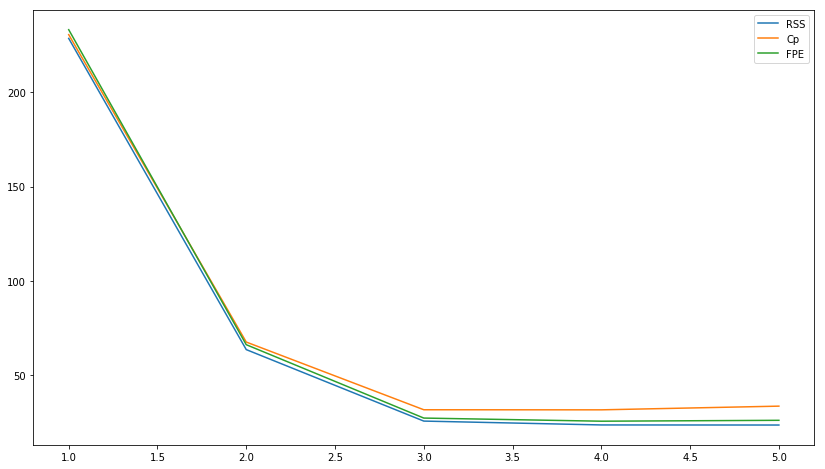

     s         RSS          Cp         FPE
0  1.0  228.424204  230.424204  233.038835
1  2.0   63.674041   67.674041   66.272981
2  3.0   25.827275   31.827275   27.424839
3  4.0   23.786365   31.786365   25.768562
4  5.0   23.740419   33.740419   26.239411
s* by Cp:  4
s* by FPE: 4

--------------------------------------------------------------
			SAMPLE #9
--------------------------------------------------------------
		CONFUGURATIONS & DATA
Sample length: n = 100
Noise generation: σ = 1
X[:10]:
[[1.59369995 1.85225793 0.49304737 0.85625434 0.55253859]
 [1.26155679 0.0796631  1.17507736 1.4832567  0.51648449]
 [0.71338897 0.85683288 0.67842936 0.54951949 1.40879388]
 [0.94865545 0.37816469 1.94804538 1.06830992 0.45854632]
 [1.54132416 0.07449061 1.76847512 0.60680002 0.7749507 ]
 [0.99603542 1.55071545 0.9715059  1.16124307 1.70637851]
 [1.07525733 1.57725067 0.25158437 0.17763358 0.69691464]
 [1.43553042 0.55434095 0.37261961 0.24971304 0.92566497]
 [1.74931225 0.48177753 0.2715507

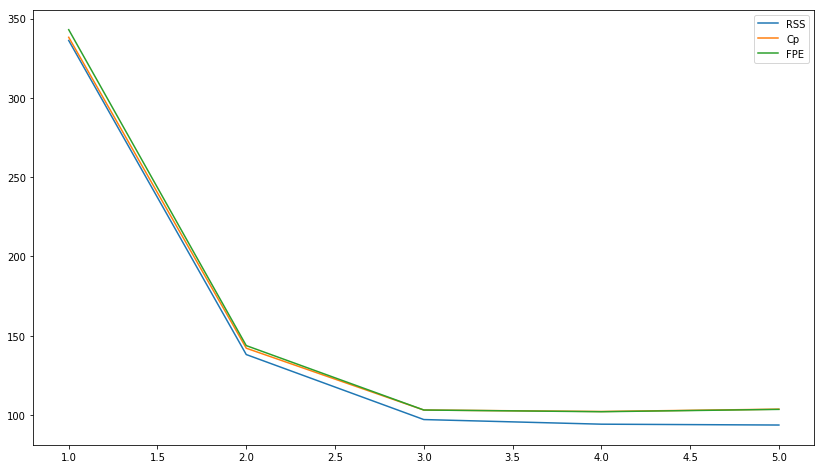

     s         RSS          Cp         FPE
0  1.0  336.167318  338.167318  342.958576
1  2.0  138.187309  142.187309  143.827608
2  3.0   97.211321  103.211321  103.224392
3  4.0   94.294903  102.294903  102.152811
4  5.0   93.759689  103.759689  103.629130
s* by Cp:  4
s* by FPE: 4



In [107]:
config.run_RMNK_model_selection()